In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt


import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
import pickle
%matplotlib inline


import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20181110/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

bird = 'B1083'
block_path = bps[bird]

# Parameters for binning
winsize = 10.0               # binning window size in milliseconds
dtovr = winsize*0.5          # window overlap in milliseconds
comment = 'ForSCM'         # We're plotting betti curves
segment_info = [0,0]       # We want the whole stimulus and just the stimulus

# Parameters for Betti curve computation
thresh = 13.0                            # Activation threshold
nperms = None                            # No permutations of the population - use full pop
ncellsperm = 20                          # Number of cells to subsample for each permuation
dims = [0,1,2,3,4]                        # Compute first five betti numbers
Ntimes = 1000                            # Number of interpolation points
stimlen = 6000                           # Stimulus length in milliseconds
twin = np.linspace(0, stimlen, Ntimes)   # Vector of interpolation time points


In [3]:
# Bin the data from each bird
bdfs = {}
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T185704Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T220619Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T222949Z-10.0-5.0.binned


In [5]:
reload(tp2)
bc_tavg_store = {}
t_store = {}
tms_store = {}
bc_tavg_shuff_store = {}

for bird in birds:
    bdf = bdfs[bird]
    block_path = bps[bird]
    # compute real and shuffled betti curves - TrialAverage
    print('Computing trial average')
    (bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    (bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr, shuffle=True)
    bc_tavg_store[bird] = bc_tavg
    bc_tavg_shuff_store[bird] = bc_tavg_shuff
    t_store[bird] = t
    tms_store[bird] = tms

Computing trial average
Computing trial average
Computing trial average
Computing trial average


In [6]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

def plot_scm_distrib(scm_bettis, bettinum, maxbin=200, ax=None, **kwargs):
    
    nmaxtot = 0
    
    bettis = scm_bettis[:, 0, bettinum]
    bettis = bettis[bettis >=0]
    #print(bettis)
    maxbettival = np.amax(bettis)
    maxbin = round(1.5*(maxbettival+1))
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettis, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [7]:
# average over all trials
import tqdm
nsamples = 200
bird_scm_dict = {}
for bird in birds:
    bdf = bdfs[bird]
    stim_dict = {}
    stim_shuffled_dict = {}
    stim_scm_dict = {}
    stim_betticurve_dict = {}
    stim_shuffled_betticurve_dict = {}
    with h5.File(bdf, 'r') as bdff:
        stims = bdff.keys()
        for stim in tqdm.tqdm(stims):
            #print(stim)
            trial=0
            stim_poptens = tp2.extract_population_tensor(bdf, stim)
            ntrials = tp2.num_trials(stim_poptens)
            stim_scm_dat= []
            stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
            scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
            stim_scm_dict[stim] = scm_bettis
    bird_scm_dict[bird] = stim_scm_dict


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [13:01, 781.89s/it]
2it [13:02, 391.20s/it]
3it [13:02, 260.95s/it]
4it [13:03, 195.84s/it]
5it [13:03, 156.77s/it]
6it [13:04, 130.71s/it]
7it [13:04, 112.10s/it]
8it [13:05, 98.14s/it] 
9it [13:05, 87.28s/it]
10it [13:05, 78.60s/it]
11it [13:06, 71.49s/it]
12it [13:06, 65.57s/it]
13it [13:07, 60.56s/it]
14it [13:07, 56.26s/it]
15it [13:08, 52.54s/it]
16it [13:08, 49.29s/it]
17it [13:09, 46.42s/it]
18it [13:09, 43.87s/it]
19it [13:10, 41.59s/it]
20it [13:10, 39.53s/it]
21it [13:11, 37.67s/it]
22it [13:11, 35.98s/it]
23it [13:12, 34.44s/it]
24it [13:12, 33.02s/it]
25it [13:12, 31.72s/it]
26it [13:13, 30.52s/it]
27it [13:13, 29.40s/it]
28it [13:14, 28.37s/it]
29it [13:14, 27.41s/it]
30it [13:15, 26.51s/it]
31it [13:15, 25.67s/it]
32it [13:16, 24.88s/it]
33it [13:16, 24.14s/it]
34it [13:16, 23.44s/it]
35it [13:17, 22.78s/it]
36it [13:17, 22.16s/it]
37it [13:18, 21.58s/it]
38it [13:18, 21.02s/it]
39it [13:19, 20.50s/it]
40it [13:19, 19.99s/it]
41it [13:20, 19.52s/it]
42it [13:20, 19.

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:16, 556.72s/it]
2it [09:16, 278.41s/it]
3it [09:16, 185.64s/it]
4it [09:17, 139.26s/it]
6it [09:17, 92.87s/it] 
8it [09:17, 69.68s/it]
9it [09:17, 61.95s/it]
11it [09:17, 50.70s/it]
12it [09:17, 46.48s/it]
14it [09:17, 39.86s/it]
15it [09:18, 37.21s/it]
17it [09:18, 32.84s/it]
19it [09:18, 29.40s/it]
21it [09:18, 26.60s/it]
23it [09:18, 24.30s/it]
25it [09:19, 22.36s/it]
27it [09:19, 20.71s/it]
29it [09:19, 19.29s/it]
31it [09:19, 18.05s/it]
33it [09:19, 16.96s/it]
35it [09:19, 16.00s/it]
37it [09:20, 15.14s/it]
39it [09:20, 14.37s/it]
41it [09:20, 13.67s/it]
43it [09:20, 13.04s/it]
45it [09:20, 12.46s/it]
47it [09:21, 11.94s/it]
49it [09:21, 11.45s/it]
51it [09:21, 11.01s/it]
53it [09:21, 10.60s/it]
55it [09:21, 10.22s/it]
57it [09:22,  9.86s/it]
59it [09:22,  9.53s/it]
61it [09:22,  9.22s/it]
63it [09:22,  8.93s/it]
65it [09:22,  8.66s/it]
67it [09:22,  8.40s/it]
69it [09:23,  8.16s/it]
71it [09:23,  7.94s/it]
73it [09:23,  7.72s/it]
75it [09:23,  7.52s/it]
77it [09:23,  7.3

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [09:27, 567.14s/it]
2it [09:27, 283.66s/it]
3it [09:27, 189.16s/it]
4it [09:27, 141.92s/it]
5it [09:27, 113.57s/it]
6it [09:28, 94.68s/it] 
7it [09:28, 81.18s/it]
8it [09:28, 71.05s/it]
9it [09:28, 63.18s/it]
10it [09:28, 56.88s/it]
11it [09:28, 51.72s/it]
12it [09:29, 47.43s/it]
13it [09:29, 43.79s/it]
14it [09:29, 40.68s/it]
15it [09:29, 37.98s/it]
16it [09:29, 35.61s/it]
17it [09:29, 33.53s/it]
18it [09:30, 31.68s/it]
19it [09:30, 30.02s/it]
20it [09:30, 28.53s/it]
21it [09:30, 27.18s/it]
22it [09:30, 25.95s/it]
23it [09:31, 24.83s/it]
24it [09:31, 23.80s/it]
25it [09:31, 22.85s/it]
26it [09:31, 21.98s/it]
27it [09:31, 21.17s/it]
28it [09:31, 20.42s/it]
29it [09:32, 19.73s/it]
30it [09:32, 19.07s/it]
31it [09:32, 18.46s/it]
32it [09:32, 17.89s/it]
33it [09:32, 17.36s/it]
34it [09:32, 16.85s/it]
35it [09:33, 16.37s/it]
36it [09:33, 15.93s/it]
37it [09:33, 15.50s/it]
38it [09:33, 15.10s/it]
39it [09:33, 14.71s/it]
40it [09:34, 14.35s/it]
41it [09:34, 14.00s/it]
42it [09:34, 13.68

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:21, 261.25s/it]
2it [04:21, 130.78s/it]
3it [04:21, 87.28s/it] 
4it [04:22, 65.54s/it]
5it [04:22, 52.49s/it]
6it [04:22, 43.79s/it]
7it [04:23, 37.59s/it]
8it [04:23, 32.93s/it]
9it [04:23, 29.30s/it]
10it [04:24, 26.41s/it]
11it [04:24, 24.04s/it]
12it [04:24, 22.06s/it]
13it [04:25, 20.39s/it]
14it [04:25, 18.96s/it]
15it [04:25, 17.71s/it]
16it [04:26, 16.63s/it]
17it [04:26, 15.67s/it]
18it [04:26, 14.81s/it]
19it [04:26, 14.05s/it]
20it [04:27, 13.36s/it]
21it [04:27, 12.74s/it]
22it [04:27, 12.18s/it]
23it [04:28, 11.66s/it]
24it [04:28, 11.19s/it]
25it [04:28, 10.75s/it]
26it [04:29, 10.35s/it]
27it [04:29,  9.98s/it]
28it [04:29,  9.64s/it]
29it [04:30,  9.31s/it]
30it [04:30,  9.02s/it]
31it [04:30,  8.73s/it]
32it [04:31,  8.47s/it]
33it [04:31,  8.22s/it]
34it [04:31,  7.99s/it]
35it [04:32,  7.77s/it]
36it [04:32,  7.57s/it]
37it [04:32,  7.37s/it]
38it [04:33,  7.19s/it]
39it [04:33,  7.01s/it]
40it [04:33,  6.84s/it]
41it [04:33,  6.68s/it]
42it [04:34,  6.53s/i

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [11:45, 705.52s/it]
2it [11:45, 352.83s/it]
3it [11:45, 235.26s/it]
4it [11:45, 176.48s/it]
5it [11:46, 141.22s/it]
6it [11:46, 117.71s/it]
7it [11:46, 100.91s/it]
8it [11:46, 88.32s/it] 
9it [11:46, 78.52s/it]
10it [11:46, 70.68s/it]
11it [11:46, 64.27s/it]
12it [11:47, 58.93s/it]
13it [11:47, 54.41s/it]
14it [11:47, 50.53s/it]
15it [11:47, 47.17s/it]
16it [11:47, 44.23s/it]
17it [11:47, 41.64s/it]
18it [11:48, 39.33s/it]
19it [11:48, 37.27s/it]
20it [11:48, 35.42s/it]
21it [11:48, 33.74s/it]
22it [11:48, 32.21s/it]
23it [11:48, 30.82s/it]
24it [11:48, 29.54s/it]
25it [11:49, 28.36s/it]
26it [11:49, 27.28s/it]
27it [11:49, 26.27s/it]
28it [11:49, 25.34s/it]
29it [11:49, 24.47s/it]
30it [11:49, 23.66s/it]
31it [11:49, 22.90s/it]
32it [11:50, 22.19s/it]
33it [11:50, 21.52s/it]
34it [11:50, 20.89s/it]
35it [11:50, 20.30s/it]
36it [11:50, 19.74s/it]
37it [11:50, 19.21s/it]
38it [11:50, 18.71s/it]
39it [11:51, 18.23s/it]
40it [11:51, 17.78s/it]
41it [11:51, 17.35s/it]
42it [11:51, 16.

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [12:35, 755.65s/it]
2it [12:36, 378.04s/it]
3it [12:36, 252.13s/it]
4it [12:36, 189.20s/it]
5it [12:37, 151.43s/it]
6it [12:37, 126.24s/it]
7it [12:37, 108.25s/it]
8it [12:38, 94.76s/it] 
9it [12:38, 84.27s/it]
10it [12:38, 75.88s/it]
11it [12:39, 69.01s/it]
12it [12:39, 63.29s/it]
13it [12:39, 58.45s/it]
14it [12:40, 54.29s/it]
15it [12:40, 50.70s/it]
16it [12:40, 47.55s/it]
17it [12:41, 44.77s/it]
18it [12:41, 42.31s/it]
19it [12:41, 40.10s/it]
20it [12:42, 38.11s/it]
21it [12:42, 36.31s/it]
22it [12:42, 34.68s/it]
23it [12:43, 33.18s/it]
24it [12:43, 31.82s/it]
25it [12:43, 30.55s/it]
26it [12:44, 29.39s/it]
27it [12:44, 28.32s/it]
28it [12:44, 27.32s/it]
29it [12:45, 26.39s/it]
30it [12:45, 25.52s/it]
31it [12:45, 24.71s/it]
32it [12:46, 23.95s/it]
33it [12:46, 23.23s/it]
34it [12:46, 22.56s/it]
35it [12:47, 21.92s/it]
36it [12:47, 21.32s/it]
37it [12:47, 20.76s/it]
38it [12:48, 20.22s/it]
39it [12:48, 19.71s/it]
40it [12:48, 19.22s/it]
41it [12:49, 18.76s/it]
42it [12:49, 18.

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [06:00, 360.03s/it]
6it [06:00, 60.02s/it] 
10it [06:00, 36.02s/it]
15it [06:00, 24.02s/it]
20it [06:00, 18.02s/it]
25it [06:00, 14.42s/it]
30it [06:00, 12.02s/it]
35it [06:00, 10.31s/it]
40it [06:00,  9.02s/it]
45it [06:01,  8.02s/it]
50it [06:01,  7.22s/it]
55it [06:01,  6.57s/it]
60it [06:01,  6.02s/it]
65it [06:01,  5.56s/it]
70it [06:01,  5.17s/it]
75it [06:01,  4.82s/it]
80it [06:01,  4.52s/it]
85it [06:02,  4.26s/it]
90it [06:02,  4.02s/it]
95it [06:02,  3.81s/it]
100it [06:02,  3.62s/it]
105it [06:02,  3.45s/it]
110it [06:02,  3.30s/it]
115it [06:02,  3.15s/it]
120it [06:02,  3.02s/it]
125it [06:02,  2.90s/it]
130it [06:03,  2.79s/it]
135it [06:03,  2.69s/it]
140it [06:03,  2.60s/it]
145it [06:03,  2.51s/it]
150it [06:03,  2.42s/it]
155it [06:03,  2.35s/it]
160it [06:03,  2.27s/it]
165it [06:03,  2.21s/it]
170it [06:04,  2.14s/it]
175it [06:04,  2.08s/it]
180it [06:04,  2.02s/it]
185it [06:04,  1.97s/it]
190it [06:04,  1.92s/it]
195it [06:04,  1.87s/it]
200it [06:04,  1.82

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [06:14, 374.13s/it]
4it [06:14, 93.56s/it] 
7it [06:14, 53.48s/it]
10it [06:14, 37.45s/it]
13it [06:14, 28.81s/it]
16it [06:14, 23.42s/it]
19it [06:14, 19.73s/it]
22it [06:14, 17.04s/it]
25it [06:15, 15.00s/it]
28it [06:15, 13.40s/it]
31it [06:15, 12.11s/it]
34it [06:15, 11.04s/it]
37it [06:15, 10.15s/it]
40it [06:15,  9.39s/it]
43it [06:15,  8.74s/it]
46it [06:15,  8.17s/it]
49it [06:15,  7.67s/it]
52it [06:16,  7.23s/it]
55it [06:16,  6.84s/it]
58it [06:16,  6.49s/it]
61it [06:16,  6.17s/it]
64it [06:16,  5.88s/it]
67it [06:16,  5.62s/it]
70it [06:16,  5.38s/it]
73it [06:16,  5.16s/it]
76it [06:16,  4.96s/it]
79it [06:17,  4.77s/it]
82it [06:17,  4.60s/it]
85it [06:17,  4.44s/it]
88it [06:17,  4.29s/it]
91it [06:17,  4.15s/it]
94it [06:17,  4.02s/it]
97it [06:17,  3.89s/it]
100it [06:17,  3.78s/it]
103it [06:17,  3.67s/it]
106it [06:18,  3.57s/it]
109it [06:18,  3.47s/it]
112it [06:18,  3.38s/it]
115it [06:18,  3.29s/it]
118it [06:18,  3.21s/it]
121it [06:18,  3.13s/it]
124it [0

Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [01:24, 84.79s/it]
7it [01:24, 12.13s/it]
13it [01:25,  6.54s/it]
19it [01:25,  4.48s/it]
25it [01:25,  3.41s/it]
31it [01:25,  2.75s/it]
37it [01:25,  2.31s/it]
43it [01:25,  1.99s/it]
49it [01:25,  1.75s/it]
55it [01:25,  1.56s/it]
61it [01:25,  1.41s/it]
67it [01:26,  1.28s/it]
73it [01:26,  1.18s/it]
79it [01:26,  1.09s/it]
85it [01:26,  1.02s/it]
91it [01:26,  1.05it/s]
97it [01:26,  1.12it/s]
103it [01:26,  1.19it/s]
109it [01:26,  1.26it/s]
115it [01:26,  1.32it/s]
121it [01:27,  1.39it/s]
127it [01:27,  1.46it/s]
133it [01:27,  1.52it/s]
139it [01:27,  1.59it/s]
145it [01:27,  1.66it/s]
151it [01:27,  1.72it/s]
157it [01:27,  1.79it/s]
163it [01:27,  1.86it/s]
169it [01:27,  1.92it/s]
175it [01:28,  1.99it/s]
181it [01:28,  2.05it/s]
187it [01:28,  2.12it/s]
193it [01:28,  2.18it/s]
199it [01:28,  2.25it/s]
  6%|▋         | 1/16 [01:28<22:07, 88.50s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:50, 50.79s/it]
11it [00:50,  4.63s/it]
21it [00:50,  2.43s/it]
31it [00:51,  1.65s/it]
41it [00:51,  1.25s/it]
50it [00:51,  1.03s/it]
59it [00:51,  1.15it/s]
68it [00:51,  1.32it/s]
77it [00:51,  1.49it/s]
87it [00:51,  1.68it/s]
96it [00:51,  1.85it/s]
105it [00:51,  2.02it/s]
114it [00:52,  2.19it/s]
124it [00:52,  2.38it/s]
133it [00:52,  2.54it/s]
143it [00:52,  2.73it/s]
153it [00:52,  2.92it/s]
163it [00:52,  3.10it/s]
173it [00:52,  3.28it/s]
183it [00:52,  3.47it/s]
193it [00:52,  3.65it/s]
 12%|█▎        | 2/16 [02:21<16:30, 70.76s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [00:59, 59.56s/it]
10it [00:59,  5.97s/it]
19it [00:59,  3.15s/it]
28it [00:59,  2.14s/it]
37it [00:59,  1.62s/it]
46it [01:00,  1.31s/it]
55it [01:00,  1.09s/it]
63it [01:00,  1.04it/s]
72it [01:00,  1.19it/s]
81it [01:00,  1.34it/s]
90it [01:00,  1.48it/s]
99it [01:00,  1.63it/s]
108it [01:00,  1.78it/s]
117it [01:00,  1.92it/s]
126it [01:01,  2.06it/s]
135it [01:01,  2.21it/s]
144it [01:01,  2.35it/s]
153it [01:01,  2.49it/s]
162it [01:01,  2.64it/s]
171it [01:01,  2.78it/s]
180it [01:01,  2.92it/s]
189it [01:01,  3.06it/s]
198it [01:01,  3.20it/s]
 19%|█▉        | 3/16 [03:23<14:41, 67.82s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [00:21, 21.06s/it]
12it [00:21,  1.76s/it]
23it [00:21,  1.08it/s]
34it [00:21,  1.59it/s]
44it [00:21,  2.05it/s]
55it [00:21,  2.55it/s]
66it [00:21,  3.04it/s]
77it [00:21,  3.53it/s]
88it [00:21,  4.02it/s]
99it [00:22,  4.50it/s]
109it [00:22,  4.93it/s]
120it [00:22,  5.40it/s]
131it [00:22,  5.87it/s]
142it [00:22,  6.33it/s]
153it [00:22,  6.79it/s]
164it [00:22,  7.24it/s]
175it [00:22,  7.69it/s]
186it [00:22,  8.14it/s]
197it [00:22,  8.58it/s]
 25%|██▌       | 4/16 [03:46<11:19, 56.62s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:04, 64.52s/it]
4it [01:04, 16.16s/it]
7it [01:04,  9.25s/it]
10it [01:04,  6.48s/it]
13it [01:04,  4.99s/it]
16it [01:05,  4.07s/it]
19it [01:05,  3.43s/it]
22it [01:05,  2.97s/it]
25it [01:05,  2.61s/it]
28it [01:05,  2.34s/it]
31it [01:05,  2.12s/it]
34it [01:05,  1.93s/it]
37it [01:05,  1.78s/it]
40it [01:05,  1.65s/it]
43it [01:06,  1.54s/it]
46it [01:06,  1.44s/it]
49it [01:06,  1.35s/it]
52it [01:06,  1.28s/it]
55it [01:06,  1.21s/it]
58it [01:06,  1.15s/it]
61it [01:06,  1.09s/it]
64it [01:06,  1.04s/it]
67it [01:06,  1.00it/s]
70it [01:06,  1.04it/s]
73it [01:07,  1.09it/s]
76it [01:07,  1.13it/s]
79it [01:07,  1.17it/s]
82it [01:07,  1.22it/s]
85it [01:07,  1.26it/s]
88it [01:07,  1.30it/s]
91it [01:07,  1.34it/s]
94it [01:07,  1.39it/s]
97it [01:07,  1.43it/s]
100it [01:08,  1.47it/s]
103it [01:08,  1.51it/s]
106it [01:08,  1.55it/s]
109it [01:08,  1.59it/s]
112it [01:08,  1.63it/s]
115it [01:08,  1.68it/s]
118it [01:08,  1.72it/s]
121it [01:08,  1.76it/s]
124it [01:

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [00:48, 48.01s/it]
8it [00:48,  6.01s/it]
12it [00:48,  4.02s/it]
21it [00:48,  2.30s/it]
29it [00:48,  1.67s/it]
37it [00:48,  1.31s/it]
45it [00:48,  1.08s/it]
53it [00:48,  1.09it/s]
61it [00:48,  1.25it/s]
69it [00:48,  1.41it/s]
78it [00:49,  1.59it/s]
86it [00:49,  1.75it/s]
94it [00:49,  1.91it/s]
102it [00:49,  2.06it/s]
110it [00:49,  2.22it/s]
118it [00:49,  2.37it/s]
126it [00:49,  2.53it/s]
135it [00:49,  2.70it/s]
143it [00:50,  2.86it/s]
152it [00:50,  3.03it/s]
160it [00:50,  3.19it/s]
168it [00:50,  3.34it/s]
177it [00:50,  3.51it/s]
186it [00:50,  3.68it/s]
195it [00:50,  3.85it/s]
 38%|███▊      | 6/16 [05:48<09:41, 58.16s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:29, 29.52s/it]
11it [00:29,  2.69s/it]
21it [00:29,  1.42s/it]
30it [00:29,  1.01it/s]
39it [00:29,  1.30it/s]
49it [00:30,  1.63it/s]
59it [00:30,  1.96it/s]
68it [00:30,  2.25it/s]
77it [00:30,  2.54it/s]
87it [00:30,  2.85it/s]
97it [00:30,  3.17it/s]
106it [00:30,  3.45it/s]
115it [00:30,  3.74it/s]
125it [00:30,  4.05it/s]
134it [00:31,  4.32it/s]
144it [00:31,  4.63it/s]
153it [00:31,  4.90it/s]
162it [00:31,  5.17it/s]
172it [00:31,  5.47it/s]
182it [00:31,  5.77it/s]
192it [00:31,  6.07it/s]
 44%|████▍     | 7/16 [06:20<08:09, 54.39s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [00:34, 34.41s/it]
11it [00:34,  3.14s/it]
21it [00:34,  1.65s/it]
31it [00:34,  1.12s/it]
41it [00:34,  1.18it/s]
50it [00:34,  1.43it/s]
59it [00:35,  1.68it/s]
69it [00:35,  1.96it/s]
79it [00:35,  2.24it/s]
89it [00:35,  2.52it/s]
99it [00:35,  2.79it/s]
109it [00:35,  3.06it/s]
119it [00:35,  3.34it/s]
129it [00:35,  3.60it/s]
139it [00:35,  3.87it/s]
149it [00:36,  4.14it/s]
159it [00:36,  4.40it/s]
169it [00:36,  4.67it/s]
179it [00:36,  4.93it/s]
189it [00:36,  5.19it/s]
199it [00:36,  5.45it/s]
 50%|█████     | 8/16 [06:57<06:57, 52.16s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:00, 60.04s/it]
8it [01:00,  7.52s/it]
15it [01:00,  4.02s/it]
22it [01:00,  2.74s/it]
29it [01:00,  2.08s/it]
36it [01:00,  1.68s/it]
44it [01:00,  1.38s/it]
51it [01:00,  1.19s/it]
59it [01:00,  1.03s/it]
66it [01:00,  1.08it/s]
73it [01:01,  1.19it/s]
80it [01:01,  1.31it/s]
87it [01:01,  1.42it/s]
94it [01:01,  1.53it/s]
102it [01:01,  1.66it/s]
109it [01:01,  1.77it/s]
116it [01:01,  1.88it/s]
123it [01:01,  1.99it/s]
131it [01:01,  2.11it/s]
138it [01:02,  2.22it/s]
146it [01:02,  2.35it/s]
153it [01:02,  2.46it/s]
160it [01:02,  2.56it/s]
167it [01:02,  2.67it/s]
174it [01:02,  2.78it/s]
181it [01:02,  2.89it/s]
188it [01:02,  2.99it/s]
195it [01:02,  3.10it/s]
 56%|█████▋    | 9/16 [08:00<06:13, 53.37s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:16, 76.98s/it]
9it [01:17,  8.57s/it]
18it [01:17,  4.29s/it]
27it [01:17,  2.86s/it]
34it [01:17,  2.28s/it]
42it [01:17,  1.85s/it]
51it [01:17,  1.52s/it]
60it [01:17,  1.30s/it]
68it [01:17,  1.14s/it]
77it [01:17,  1.01s/it]
86it [01:18,  1.10it/s]
94it [01:18,  1.20it/s]
103it [01:18,  1.32it/s]
112it [01:18,  1.43it/s]
121it [01:18,  1.54it/s]
130it [01:18,  1.65it/s]
139it [01:18,  1.77it/s]
148it [01:18,  1.88it/s]
156it [01:18,  1.98it/s]
164it [01:19,  2.07it/s]
173it [01:19,  2.19it/s]
182it [01:19,  2.30it/s]
191it [01:19,  2.41it/s]
199it [01:19,  2.50it/s]
 62%|██████▎   | 10/16 [09:19<05:35, 55.98s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:17, 77.19s/it]
6it [01:17, 12.88s/it]
11it [01:17,  7.04s/it]
16it [01:17,  4.84s/it]
21it [01:17,  3.70s/it]
26it [01:17,  2.99s/it]
31it [01:17,  2.51s/it]
36it [01:17,  2.16s/it]
41it [01:18,  1.90s/it]
46it [01:18,  1.70s/it]
51it [01:18,  1.53s/it]
56it [01:18,  1.40s/it]
61it [01:18,  1.29s/it]
66it [01:18,  1.19s/it]
71it [01:18,  1.11s/it]
76it [01:18,  1.04s/it]
81it [01:18,  1.03it/s]
86it [01:18,  1.09it/s]
92it [01:19,  1.16it/s]
97it [01:19,  1.22it/s]
103it [01:19,  1.30it/s]
108it [01:19,  1.36it/s]
113it [01:19,  1.42it/s]
118it [01:19,  1.48it/s]
123it [01:19,  1.54it/s]
129it [01:19,  1.62it/s]
135it [01:19,  1.69it/s]
140it [01:20,  1.75it/s]
145it [01:20,  1.81it/s]
150it [01:20,  1.87it/s]
155it [01:20,  1.93it/s]
160it [01:20,  1.99it/s]
165it [01:20,  2.05it/s]
170it [01:20,  2.11it/s]
175it [01:20,  2.17it/s]
180it [01:20,  2.23it/s]
185it [01:20,  2.28it/s]
191it [01:21,  2.35it/s]
196it [01:21,  2.41it/s]
 69%|██████▉   | 11/16 [10:41<04:51, 58.29s/it

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [00:41, 41.44s/it]
9it [00:41,  4.62s/it]
19it [00:41,  2.19s/it]
28it [00:41,  1.49s/it]
38it [00:41,  1.10s/it]
48it [00:41,  1.14it/s]
58it [00:42,  1.38it/s]
68it [00:42,  1.61it/s]
78it [00:42,  1.84it/s]
88it [00:42,  2.08it/s]
98it [00:42,  2.31it/s]
109it [00:42,  2.56it/s]
119it [00:42,  2.79it/s]
129it [00:42,  3.01it/s]
139it [00:42,  3.24it/s]
149it [00:43,  3.46it/s]
159it [00:43,  3.69it/s]
169it [00:43,  3.91it/s]
179it [00:43,  4.13it/s]
189it [00:43,  4.35it/s]
199it [00:43,  4.57it/s]
 75%|███████▌  | 12/16 [11:24<03:48, 57.06s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [00:42, 42.05s/it]
11it [00:42,  3.83s/it]
21it [00:42,  2.01s/it]
31it [00:42,  1.37s/it]
41it [00:42,  1.04s/it]
50it [00:42,  1.17it/s]
60it [00:42,  1.41it/s]
70it [00:42,  1.64it/s]
80it [00:42,  1.86it/s]
89it [00:43,  2.07it/s]
98it [00:43,  2.27it/s]
108it [00:43,  2.50it/s]
118it [00:43,  2.72it/s]
128it [00:43,  2.95it/s]
138it [00:43,  3.17it/s]
148it [00:43,  3.39it/s]
158it [00:43,  3.61it/s]
168it [00:43,  3.83it/s]
178it [00:43,  4.05it/s]
188it [00:44,  4.27it/s]
198it [00:44,  4.48it/s]
 81%|████████▏ | 13/16 [12:08<02:48, 56.07s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [00:44, 44.30s/it]
11it [00:44,  4.04s/it]
20it [00:44,  2.23s/it]
30it [00:44,  1.49s/it]
40it [00:44,  1.12s/it]
50it [00:44,  1.12it/s]
60it [00:44,  1.34it/s]
70it [00:45,  1.55it/s]
80it [00:45,  1.77it/s]
89it [00:45,  1.97it/s]
98it [00:45,  2.16it/s]
107it [00:45,  2.35it/s]
116it [00:45,  2.54it/s]
125it [00:45,  2.74it/s]
134it [00:45,  2.93it/s]
143it [00:45,  3.12it/s]
152it [00:46,  3.30it/s]
161it [00:46,  3.49it/s]
170it [00:46,  3.68it/s]
180it [00:46,  3.89it/s]
190it [00:46,  4.09it/s]
199it [00:46,  4.28it/s]
 88%|████████▊ | 14/16 [12:55<01:50, 55.40s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [01:11, 71.51s/it]
7it [01:11, 10.23s/it]
12it [01:11,  5.98s/it]
17it [01:11,  4.23s/it]
22it [01:11,  3.27s/it]
27it [01:12,  2.67s/it]
32it [01:12,  2.25s/it]
38it [01:12,  1.90s/it]
44it [01:12,  1.64s/it]
50it [01:12,  1.45s/it]
55it [01:12,  1.32s/it]
60it [01:12,  1.21s/it]
66it [01:12,  1.10s/it]
72it [01:12,  1.01s/it]
78it [01:13,  1.07it/s]
84it [01:13,  1.15it/s]
90it [01:13,  1.23it/s]
96it [01:13,  1.31it/s]
102it [01:13,  1.39it/s]
108it [01:13,  1.47it/s]
114it [01:13,  1.55it/s]
120it [01:13,  1.62it/s]
126it [01:13,  1.70it/s]
132it [01:14,  1.78it/s]
138it [01:14,  1.86it/s]
144it [01:14,  1.94it/s]
150it [01:14,  2.01it/s]
156it [01:14,  2.09it/s]
161it [01:14,  2.16it/s]
166it [01:14,  2.22it/s]
171it [01:14,  2.28it/s]
177it [01:15,  2.36it/s]
182it [01:15,  2.42it/s]
187it [01:15,  2.49it/s]
193it [01:15,  2.56it/s]
198it [01:15,  2.62it/s]
 94%|█████████▍| 15/16 [14:11<00:56, 56.74s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [00:34, 34.80s/it]
10it [00:34,  3.49s/it]
20it [00:35,  1.75s/it]
29it [00:35,  1.21s/it]
39it [00:35,  1.11it/s]
49it [00:35,  1.39it/s]
59it [00:35,  1.66it/s]
69it [00:35,  1.94it/s]
79it [00:35,  2.22it/s]
89it [00:35,  2.49it/s]
99it [00:35,  2.76it/s]
109it [00:35,  3.03it/s]
119it [00:36,  3.30it/s]
129it [00:36,  3.56it/s]
139it [00:36,  3.83it/s]
149it [00:36,  4.09it/s]
159it [00:36,  4.35it/s]
168it [00:36,  4.59it/s]
178it [00:36,  4.84it/s]
188it [00:36,  5.10it/s]
198it [00:37,  5.32it/s]
  0%|          | 0/16 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [00:56, 56.63s/it]
10it [00:56,  5.67s/it]
19it [00:56,  2.99s/it]
27it [00:56,  2.11s/it]
36it [00:57,  1.58s/it]
45it [00:57,  1.27s/it]
54it [00:57,  1.06s/it]
62it [00:57,  1.08it/s]
70it [00:57,  1.22it/s]
79it [00:57,  1.37it/s]
88it [00:57,  1.53it/s]
97it [00:57,  1.68it/s]
106it [00:57,  1.83it/s]
115it [00:58,  1.98it/s]
124it [00:58,  2.13it/s]
133it [00:58,  2.28it/s]
142it [00:58,  2.43it/s]
151it [00:58,  2.58it/s]
160it [00:58,  2.73it/s]
169it [00:58,  2.88it/s]
178it [00:58,  3.03it/s]
187it [00:58,  3.18it/s]
196it [00:58,  3.32it/s]
  6%|▋         | 1/16 [00:59<14:45, 59.03s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:51, 51.29s/it]
9it [00:51,  5.71s/it]
17it [00:51,  3.03s/it]
24it [00:51,  2.15s/it]
32it [00:51,  1.62s/it]
40it [00:51,  1.30s/it]
48it [00:51,  1.08s/it]
55it [00:52,  1.06it/s]
63it [00:52,  1.21it/s]
71it [00:52,  1.36it/s]
79it [00:52,  1.51it/s]
87it [00:52,  1.66it/s]
95it [00:52,  1.81it/s]
103it [00:52,  1.96it/s]
111it [00:52,  2.10it/s]
119it [00:52,  2.25it/s]
127it [00:52,  2.40it/s]
135it [00:53,  2.54it/s]
143it [00:53,  2.69it/s]
151it [00:53,  2.83it/s]
159it [00:53,  2.98it/s]
167it [00:53,  3.12it/s]
175it [00:53,  3.26it/s]
183it [00:53,  3.40it/s]
191it [00:53,  3.55it/s]
199it [00:53,  3.69it/s]
 12%|█▎        | 2/16 [01:53<13:11, 56.51s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [01:03, 63.12s/it]
8it [01:03,  7.90s/it]
15it [01:03,  4.22s/it]
22it [01:03,  2.88s/it]
29it [01:03,  2.19s/it]
36it [01:03,  1.77s/it]
43it [01:03,  1.48s/it]
50it [01:03,  1.28s/it]
57it [01:03,  1.12s/it]
64it [01:04,  1.00s/it]
71it [01:04,  1.11it/s]
78it [01:04,  1.21it/s]
85it [01:04,  1.32it/s]
92it [01:04,  1.43it/s]
99it [01:04,  1.53it/s]
106it [01:04,  1.64it/s]
113it [01:04,  1.74it/s]
120it [01:04,  1.85it/s]
127it [01:04,  1.95it/s]
134it [01:05,  2.06it/s]
141it [01:05,  2.16it/s]
148it [01:05,  2.27it/s]
155it [01:05,  2.37it/s]
162it [01:05,  2.47it/s]
169it [01:05,  2.57it/s]
176it [01:05,  2.68it/s]
183it [01:05,  2.78it/s]
190it [01:05,  2.88it/s]
197it [01:06,  2.98it/s]
 19%|█▉        | 3/16 [02:59<12:56, 59.72s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [01:19, 79.60s/it]
7it [01:19, 11.39s/it]
13it [01:19,  6.14s/it]
19it [01:19,  4.21s/it]
25it [01:20,  3.20s/it]
31it [01:20,  2.58s/it]
37it [01:20,  2.17s/it]
43it [01:20,  1.87s/it]
49it [01:20,  1.64s/it]
55it [01:20,  1.46s/it]
62it [01:20,  1.30s/it]
68it [01:20,  1.19s/it]
75it [01:20,  1.08s/it]
81it [01:20,  1.00it/s]
87it [01:21,  1.07it/s]
93it [01:21,  1.15it/s]
99it [01:21,  1.22it/s]
105it [01:21,  1.29it/s]
112it [01:21,  1.37it/s]
118it [01:21,  1.45it/s]
124it [01:21,  1.52it/s]
130it [01:21,  1.59it/s]
136it [01:21,  1.66it/s]
142it [01:22,  1.73it/s]
148it [01:22,  1.80it/s]
155it [01:22,  1.89it/s]
161it [01:22,  1.96it/s]
167it [01:22,  2.03it/s]
174it [01:22,  2.11it/s]
180it [01:22,  2.18it/s]
186it [01:22,  2.25it/s]
192it [01:22,  2.32it/s]
198it [01:22,  2.39it/s]
 25%|██▌       | 4/16 [04:22<13:06, 65.54s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:29, 89.75s/it]
9it [01:29,  9.98s/it]
17it [01:29,  5.29s/it]
25it [01:30,  3.60s/it]
33it [01:30,  2.73s/it]
42it [01:30,  2.15s/it]
50it [01:30,  1.81s/it]
58it [01:30,  1.56s/it]
66it [01:30,  1.37s/it]
75it [01:30,  1.21s/it]
83it [01:30,  1.09s/it]
92it [01:30,  1.01it/s]
100it [01:31,  1.10it/s]
109it [01:31,  1.20it/s]
117it [01:31,  1.28it/s]
125it [01:31,  1.37it/s]
133it [01:31,  1.45it/s]
141it [01:31,  1.54it/s]
149it [01:31,  1.63it/s]
157it [01:31,  1.71it/s]
166it [01:31,  1.81it/s]
174it [01:31,  1.89it/s]
182it [01:32,  1.98it/s]
190it [01:32,  2.06it/s]
198it [01:32,  2.15it/s]
 31%|███▏      | 5/16 [05:54<12:59, 70.89s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [02:05, 125.91s/it]
8it [02:06, 15.75s/it] 
15it [02:06,  8.41s/it]
22it [02:06,  5.74s/it]
29it [02:06,  4.36s/it]
36it [02:06,  3.51s/it]
43it [02:06,  2.94s/it]
50it [02:06,  2.53s/it]
57it [02:06,  2.22s/it]
64it [02:06,  1.98s/it]
71it [02:07,  1.79s/it]
78it [02:07,  1.63s/it]
85it [02:07,  1.50s/it]
92it [02:07,  1.38s/it]
99it [02:07,  1.29s/it]
106it [02:07,  1.20s/it]
113it [02:07,  1.13s/it]
120it [02:07,  1.06s/it]
127it [02:07,  1.01s/it]
134it [02:07,  1.05it/s]
141it [02:08,  1.10it/s]
148it [02:08,  1.15it/s]
155it [02:08,  1.21it/s]
162it [02:08,  1.26it/s]
169it [02:08,  1.31it/s]
176it [02:08,  1.37it/s]
183it [02:08,  1.42it/s]
190it [02:08,  1.47it/s]
197it [02:08,  1.53it/s]
 38%|███▊      | 6/16 [08:03<13:25, 80.58s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:40, 40.66s/it]
6it [00:40,  6.80s/it]
11it [00:40,  3.72s/it]
16it [00:41,  2.56s/it]
21it [00:41,  1.96s/it]
26it [00:41,  1.59s/it]
31it [00:41,  1.33s/it]
36it [00:41,  1.15s/it]
41it [00:41,  1.01s/it]
46it [00:41,  1.10it/s]
51it [00:41,  1.22it/s]
56it [00:41,  1.33it/s]
61it [00:42,  1.45it/s]
66it [00:42,  1.56it/s]
71it [00:42,  1.68it/s]
76it [00:42,  1.79it/s]
81it [00:42,  1.90it/s]
86it [00:42,  2.02it/s]
91it [00:42,  2.13it/s]
96it [00:42,  2.24it/s]
101it [00:43,  2.35it/s]
106it [00:43,  2.46it/s]
111it [00:43,  2.56it/s]
116it [00:43,  2.67it/s]
121it [00:43,  2.78it/s]
126it [00:43,  2.89it/s]
131it [00:43,  2.99it/s]
136it [00:43,  3.10it/s]
141it [00:44,  3.20it/s]
146it [00:44,  3.31it/s]
151it [00:44,  3.41it/s]
156it [00:44,  3.52it/s]
161it [00:44,  3.62it/s]
166it [00:44,  3.72it/s]
171it [00:44,  3.82it/s]
176it [00:44,  3.92it/s]
181it [00:44,  4.02it/s]
186it [00:45,  4.13it/s]
191it [00:45,  4.23it/s]
196it [00:45,  4.32it/s]
 44%|████▍     | 7/16

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [01:42, 102.99s/it]
4it [01:43, 25.77s/it] 
7it [01:43, 14.74s/it]
10it [01:43, 10.33s/it]
13it [01:43,  7.96s/it]
16it [01:43,  6.47s/it]
19it [01:43,  5.46s/it]
22it [01:43,  4.72s/it]
25it [01:43,  4.16s/it]
28it [01:43,  3.71s/it]
31it [01:44,  3.36s/it]
34it [01:44,  3.06s/it]
37it [01:44,  2.82s/it]
40it [01:44,  2.61s/it]
43it [01:44,  2.43s/it]
46it [01:44,  2.28s/it]
49it [01:44,  2.14s/it]
52it [01:44,  2.02s/it]
55it [01:45,  1.91s/it]
58it [01:45,  1.81s/it]
61it [01:45,  1.73s/it]
64it [01:45,  1.65s/it]
67it [01:45,  1.58s/it]
70it [01:45,  1.51s/it]
73it [01:45,  1.45s/it]
76it [01:45,  1.39s/it]
79it [01:45,  1.34s/it]
82it [01:46,  1.29s/it]
85it [01:46,  1.25s/it]
88it [01:46,  1.21s/it]
91it [01:46,  1.17s/it]
94it [01:46,  1.13s/it]
97it [01:46,  1.10s/it]
100it [01:46,  1.07s/it]
103it [01:46,  1.04s/it]
106it [01:47,  1.01s/it]
109it [01:47,  1.02it/s]
112it [01:47,  1.04it/s]
115it [01:47,  1.07it/s]
118it [01:47,  1.10it/s]
121it [01:47,  1.12it/s]
124it [0

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:48, 108.95s/it]
5it [01:49, 21.81s/it] 
9it [01:49, 12.13s/it]
13it [01:49,  8.41s/it]
17it [01:49,  6.44s/it]
21it [01:49,  5.22s/it]
25it [01:49,  4.39s/it]
29it [01:49,  3.78s/it]
33it [01:49,  3.33s/it]
37it [01:49,  2.97s/it]
41it [01:50,  2.69s/it]
45it [01:50,  2.45s/it]
49it [01:50,  2.25s/it]
53it [01:50,  2.08s/it]
57it [01:50,  1.94s/it]
61it [01:50,  1.81s/it]
65it [01:50,  1.70s/it]
69it [01:50,  1.61s/it]
73it [01:51,  1.52s/it]
77it [01:51,  1.44s/it]
81it [01:51,  1.37s/it]
85it [01:51,  1.31s/it]
89it [01:51,  1.25s/it]
93it [01:51,  1.20s/it]
97it [01:51,  1.15s/it]
101it [01:51,  1.11s/it]
105it [01:51,  1.07s/it]
109it [01:52,  1.03s/it]
113it [01:52,  1.01it/s]
117it [01:52,  1.04it/s]
121it [01:52,  1.08it/s]
125it [01:52,  1.11it/s]
129it [01:52,  1.15it/s]
133it [01:52,  1.18it/s]
137it [01:52,  1.21it/s]
141it [01:53,  1.25it/s]
145it [01:53,  1.28it/s]
149it [01:53,  1.32it/s]
153it [01:53,  1.35it/s]
157it [01:53,  1.38it/s]
161it [01:53,  1.42it/s]


Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:10, 70.33s/it]
8it [01:10,  8.81s/it]
16it [01:10,  4.41s/it]
25it [01:10,  2.83s/it]
33it [01:10,  2.14s/it]
41it [01:10,  1.73s/it]
49it [01:10,  1.45s/it]
58it [01:11,  1.23s/it]
66it [01:11,  1.08s/it]
75it [01:11,  1.05it/s]
83it [01:11,  1.16it/s]
92it [01:11,  1.29it/s]
101it [01:11,  1.41it/s]
110it [01:11,  1.53it/s]
118it [01:11,  1.64it/s]
126it [01:11,  1.75it/s]
134it [01:12,  1.86it/s]
142it [01:12,  1.97it/s]
150it [01:12,  2.08it/s]
158it [01:12,  2.18it/s]
166it [01:12,  2.29it/s]
174it [01:12,  2.40it/s]
183it [01:12,  2.52it/s]
192it [01:12,  2.64it/s]
 62%|██████▎   | 10/16 [13:47<08:16, 82.74s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:04, 64.38s/it]
10it [01:04,  6.45s/it]
18it [01:04,  3.59s/it]
26it [01:04,  2.49s/it]
34it [01:04,  1.91s/it]
42it [01:04,  1.55s/it]
50it [01:05,  1.30s/it]
58it [01:05,  1.12s/it]
66it [01:05,  1.01it/s]
74it [01:05,  1.13it/s]
82it [01:05,  1.25it/s]
90it [01:05,  1.37it/s]
98it [01:05,  1.49it/s]
106it [01:05,  1.61it/s]
114it [01:05,  1.73it/s]
122it [01:05,  1.85it/s]
130it [01:06,  1.97it/s]
138it [01:06,  2.08it/s]
146it [01:06,  2.20it/s]
154it [01:06,  2.32it/s]
162it [01:06,  2.43it/s]
169it [01:06,  2.53it/s]
177it [01:06,  2.65it/s]
185it [01:06,  2.76it/s]
193it [01:07,  2.88it/s]
 69%|██████▉   | 11/16 [14:54<06:46, 81.33s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [01:30, 90.69s/it]
8it [01:30, 11.35s/it]
15it [01:30,  6.06s/it]
22it [01:31,  4.14s/it]
29it [01:31,  3.14s/it]
36it [01:31,  2.53s/it]
43it [01:31,  2.12s/it]
50it [01:31,  1.83s/it]
57it [01:31,  1.61s/it]
64it [01:31,  1.43s/it]
71it [01:31,  1.29s/it]
78it [01:31,  1.18s/it]
85it [01:32,  1.08s/it]
92it [01:32,  1.00s/it]
99it [01:32,  1.07it/s]
106it [01:32,  1.15it/s]
113it [01:32,  1.22it/s]
120it [01:32,  1.30it/s]
127it [01:32,  1.37it/s]
134it [01:32,  1.44it/s]
141it [01:32,  1.52it/s]
148it [01:33,  1.59it/s]
155it [01:33,  1.66it/s]
162it [01:33,  1.74it/s]
169it [01:33,  1.81it/s]
176it [01:33,  1.88it/s]
183it [01:33,  1.96it/s]
190it [01:33,  2.03it/s]
197it [01:33,  2.10it/s]
 75%|███████▌  | 12/16 [16:28<05:29, 82.37s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [01:05, 65.61s/it]
9it [01:05,  7.30s/it]
17it [01:05,  3.87s/it]
25it [01:05,  2.64s/it]
33it [01:06,  2.00s/it]
41it [01:06,  1.61s/it]
49it [01:06,  1.35s/it]
57it [01:06,  1.16s/it]
65it [01:06,  1.02s/it]
74it [01:06,  1.11it/s]
82it [01:06,  1.23it/s]
90it [01:06,  1.35it/s]
98it [01:06,  1.47it/s]
107it [01:06,  1.60it/s]
115it [01:07,  1.71it/s]
123it [01:07,  1.83it/s]
131it [01:07,  1.95it/s]
139it [01:07,  2.06it/s]
147it [01:07,  2.18it/s]
155it [01:07,  2.29it/s]
164it [01:07,  2.42it/s]
173it [01:07,  2.55it/s]
182it [01:07,  2.68it/s]
190it [01:08,  2.79it/s]
199it [01:08,  2.92it/s]
 81%|████████▏ | 13/16 [17:36<04:03, 81.28s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [01:49, 109.26s/it]
4it [01:49, 27.34s/it] 
7it [01:49, 15.64s/it]
10it [01:49, 10.96s/it]
13it [01:49,  8.44s/it]
17it [01:49,  6.46s/it]
20it [01:49,  5.50s/it]
24it [01:50,  4.59s/it]
27it [01:50,  4.08s/it]
30it [01:50,  3.68s/it]
34it [01:50,  3.25s/it]
38it [01:50,  2.91s/it]
42it [01:50,  2.64s/it]
45it [01:50,  2.46s/it]
49it [01:50,  2.26s/it]
53it [01:51,  2.10s/it]
57it [01:51,  1.95s/it]
61it [01:51,  1.82s/it]
65it [01:51,  1.71s/it]
69it [01:51,  1.62s/it]
73it [01:51,  1.53s/it]
77it [01:51,  1.45s/it]
81it [01:51,  1.38s/it]
85it [01:52,  1.32s/it]
89it [01:52,  1.26s/it]
92it [01:52,  1.22s/it]
96it [01:52,  1.17s/it]
99it [01:52,  1.14s/it]
102it [01:52,  1.10s/it]
105it [01:52,  1.07s/it]
109it [01:52,  1.04s/it]
112it [01:53,  1.01s/it]
115it [01:53,  1.02it/s]
118it [01:53,  1.04it/s]
121it [01:53,  1.07it/s]
124it [01:53,  1.09it/s]
127it [01:53,  1.12it/s]
130it [01:53,  1.14it/s]
134it [01:53,  1.18it/s]
138it [01:53,  1.21it/s]
142it [01:54,  1.24it/s]
145

Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [00:57, 57.58s/it]
10it [00:57,  5.77s/it]
19it [00:57,  3.04s/it]
28it [00:57,  2.07s/it]
37it [00:58,  1.57s/it]
46it [00:58,  1.26s/it]
55it [00:58,  1.06s/it]
64it [00:58,  1.10it/s]
72it [00:58,  1.23it/s]
81it [00:58,  1.38it/s]
90it [00:58,  1.53it/s]
99it [00:58,  1.68it/s]
108it [00:58,  1.83it/s]
117it [00:58,  1.98it/s]
126it [00:59,  2.13it/s]
135it [00:59,  2.28it/s]
144it [00:59,  2.43it/s]
153it [00:59,  2.58it/s]
162it [00:59,  2.72it/s]
171it [00:59,  2.87it/s]
180it [00:59,  3.01it/s]
189it [00:59,  3.16it/s]
198it [00:59,  3.30it/s]
 94%|█████████▍| 15/16 [20:32<01:22, 82.18s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [01:32, 92.20s/it]
6it [01:32, 15.39s/it]
11it [01:32,  8.40s/it]
16it [01:32,  5.78s/it]
21it [01:32,  4.41s/it]
26it [01:32,  3.57s/it]
31it [01:32,  3.00s/it]
36it [01:32,  2.58s/it]
41it [01:33,  2.27s/it]
46it [01:33,  2.03s/it]
51it [01:33,  1.83s/it]
56it [01:33,  1.67s/it]
61it [01:33,  1.53s/it]
66it [01:33,  1.42s/it]
71it [01:33,  1.32s/it]
76it [01:33,  1.24s/it]
81it [01:34,  1.16s/it]
86it [01:34,  1.09s/it]
91it [01:34,  1.04s/it]
96it [01:34,  1.02it/s]
101it [01:34,  1.07it/s]
106it [01:34,  1.12it/s]
111it [01:34,  1.17it/s]
116it [01:34,  1.22it/s]
121it [01:34,  1.27it/s]
126it [01:35,  1.33it/s]
131it [01:35,  1.38it/s]
136it [01:35,  1.43it/s]
141it [01:35,  1.48it/s]
146it [01:35,  1.53it/s]
151it [01:35,  1.58it/s]
156it [01:35,  1.63it/s]
161it [01:35,  1.68it/s]
166it [01:35,  1.73it/s]
171it [01:36,  1.78it/s]
176it [01:36,  1.83it/s]
181it [01:36,  1.88it/s]
186it [01:36,  1.93it/s]
191it [01:36,  1.98it/s]
196it [01:36,  2.03it/s]
  0%|          | 0/16

Extracting Population Activity Tensor...
Stim: A_40k, Clusters:None



1it [00:29, 29.87s/it]
11it [00:29,  2.72s/it]
20it [00:30,  1.50s/it]
30it [00:30,  1.01s/it]
39it [00:30,  1.29it/s]
49it [00:30,  1.61it/s]
59it [00:30,  1.93it/s]
69it [00:30,  2.25it/s]
78it [00:30,  2.54it/s]
87it [00:30,  2.82it/s]
97it [00:30,  3.14it/s]
107it [00:31,  3.45it/s]
116it [00:31,  3.72it/s]
126it [00:31,  4.03it/s]
136it [00:31,  4.34it/s]
145it [00:31,  4.61it/s]
154it [00:31,  4.88it/s]
164it [00:31,  5.18it/s]
174it [00:31,  5.47it/s]
184it [00:31,  5.77it/s]
194it [00:31,  6.06it/s]
  6%|▋         | 1/16 [00:32<08:01, 32.07s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_40k, Clusters:None



1it [01:10, 70.74s/it]
8it [01:10,  8.86s/it]
15it [01:10,  4.73s/it]
22it [01:11,  3.23s/it]
29it [01:11,  2.45s/it]
36it [01:11,  1.98s/it]
43it [01:11,  1.66s/it]
49it [01:11,  1.46s/it]
56it [01:11,  1.28s/it]
63it [01:11,  1.14s/it]
70it [01:11,  1.03s/it]
77it [01:11,  1.07it/s]
84it [01:12,  1.17it/s]
91it [01:12,  1.26it/s]
98it [01:12,  1.36it/s]
105it [01:12,  1.45it/s]
112it [01:12,  1.55it/s]
119it [01:12,  1.64it/s]
126it [01:12,  1.73it/s]
133it [01:12,  1.83it/s]
140it [01:12,  1.92it/s]
147it [01:13,  2.01it/s]
154it [01:13,  2.11it/s]
161it [01:13,  2.20it/s]
168it [01:13,  2.29it/s]
175it [01:13,  2.38it/s]
182it [01:13,  2.47it/s]
189it [01:13,  2.56it/s]
196it [01:13,  2.66it/s]
 12%|█▎        | 2/16 [01:45<12:21, 52.97s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_40k, Clusters:None



1it [00:14, 14.65s/it]
13it [00:14,  1.14s/it]
25it [00:14,  1.68it/s]
37it [00:14,  2.47it/s]
47it [00:15,  3.12it/s]
58it [00:15,  3.82it/s]
69it [00:15,  4.52it/s]
80it [00:15,  5.20it/s]
91it [00:15,  5.88it/s]
103it [00:15,  6.61it/s]
114it [00:15,  7.27it/s]
125it [00:15,  7.92it/s]
136it [00:15,  8.56it/s]
148it [00:15,  9.25it/s]
160it [00:16,  9.94it/s]
172it [00:16, 10.62it/s]
184it [00:16, 11.28it/s]
196it [00:16, 11.94it/s]
 19%|█▉        | 3/16 [02:02<08:50, 40.80s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_40k, Clusters:None



1it [00:13, 13.15s/it]
13it [00:13,  1.02s/it]
25it [00:13,  1.87it/s]
36it [00:13,  2.67it/s]
48it [00:13,  3.54it/s]
59it [00:13,  4.31it/s]
70it [00:13,  5.08it/s]
81it [00:13,  5.84it/s]
92it [00:13,  6.58it/s]
104it [00:14,  7.38it/s]
115it [00:14,  8.10it/s]
126it [00:14,  8.81it/s]
137it [00:14,  9.52it/s]
148it [00:14, 10.21it/s]
160it [00:14, 10.95it/s]
172it [00:14, 11.69it/s]
184it [00:14, 12.42it/s]
196it [00:14, 13.14it/s]
 25%|██▌       | 4/16 [02:17<06:52, 34.35s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_40k, Clusters:None



1it [00:36, 36.09s/it]
11it [00:36,  3.29s/it]
21it [00:36,  1.73s/it]
32it [00:36,  1.14s/it]
42it [00:36,  1.15it/s]
53it [00:36,  1.45it/s]
64it [00:36,  1.74it/s]
75it [00:36,  2.04it/s]
85it [00:36,  2.30it/s]
95it [00:37,  2.57it/s]
105it [00:37,  2.83it/s]
115it [00:37,  3.09it/s]
125it [00:37,  3.35it/s]
136it [00:37,  3.63it/s]
147it [00:37,  3.91it/s]
158it [00:37,  4.20it/s]
169it [00:37,  4.47it/s]
179it [00:37,  4.73it/s]
189it [00:37,  4.98it/s]
199it [00:38,  5.22it/s]
 31%|███▏      | 5/16 [02:55<06:26, 35.10s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_40k, Clusters:None



1it [00:16, 16.29s/it]
13it [00:16,  1.26s/it]
24it [00:16,  1.45it/s]
35it [00:16,  2.11it/s]
46it [00:16,  2.75it/s]
58it [00:16,  3.45it/s]
69it [00:16,  4.08it/s]
79it [00:17,  4.63it/s]
90it [00:17,  5.25it/s]
102it [00:17,  5.91it/s]
113it [00:17,  6.51it/s]
125it [00:17,  7.16it/s]
137it [00:17,  7.80it/s]
149it [00:17,  8.43it/s]
161it [00:17,  9.05it/s]
173it [00:17,  9.67it/s]
185it [00:18, 10.28it/s]
197it [00:18, 10.88it/s]
 38%|███▊      | 6/16 [03:13<05:22, 32.28s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_40k, Clusters:None



1it [00:13, 13.44s/it]
12it [00:13,  1.13s/it]
23it [00:13,  1.69it/s]
34it [00:13,  2.47it/s]
45it [00:13,  3.25it/s]
57it [00:13,  4.08it/s]
69it [00:14,  4.90it/s]
80it [00:14,  5.65it/s]
92it [00:14,  6.44it/s]
103it [00:14,  7.16it/s]
114it [00:14,  7.87it/s]
125it [00:14,  8.57it/s]
137it [00:14,  9.33it/s]
149it [00:14, 10.07it/s]
160it [00:14, 10.71it/s]
171it [00:15, 11.37it/s]
182it [00:15, 12.02it/s]
193it [00:15, 12.65it/s]
 44%|████▍     | 7/16 [03:28<04:28, 29.86s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_40k, Clusters:None



1it [00:12, 12.70s/it]
14it [00:12,  1.09it/s]
27it [00:12,  2.09it/s]
38it [00:13,  2.92it/s]
49it [00:13,  3.74it/s]
60it [00:13,  4.54it/s]
72it [00:13,  5.41it/s]
85it [00:13,  6.33it/s]
97it [00:13,  7.17it/s]
110it [00:13,  8.07it/s]
122it [00:13,  8.88it/s]
134it [00:13,  9.68it/s]
146it [00:13, 10.47it/s]
158it [00:14, 11.24it/s]
170it [00:14, 12.01it/s]
182it [00:14, 12.76it/s]
194it [00:14, 13.50it/s]
 50%|█████     | 8/16 [03:43<03:43, 27.93s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [00:32, 32.92s/it]
11it [00:33,  3.00s/it]
15it [00:33,  2.21s/it]
19it [00:33,  1.75s/it]
28it [00:33,  1.19s/it]
38it [00:33,  1.14it/s]
48it [00:33,  1.43it/s]
58it [00:33,  1.72it/s]
67it [00:33,  1.98it/s]
76it [00:33,  2.24it/s]
85it [00:34,  2.50it/s]
95it [00:34,  2.79it/s]
105it [00:34,  3.07it/s]
114it [00:34,  3.32it/s]
123it [00:34,  3.57it/s]
132it [00:34,  3.82it/s]
142it [00:34,  4.10it/s]
151it [00:34,  4.35it/s]
160it [00:34,  4.59it/s]
170it [00:34,  4.87it/s]
179it [00:35,  5.11it/s]
189it [00:35,  5.38it/s]
198it [00:35,  5.62it/s]
 56%|█████▋    | 9/16 [04:18<03:21, 28.75s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [00:12, 12.55s/it]
13it [00:12,  1.03it/s]
24it [00:12,  1.88it/s]
36it [00:12,  2.80it/s]
47it [00:12,  3.62it/s]
58it [00:13,  4.43it/s]
69it [00:13,  5.23it/s]
80it [00:13,  6.02it/s]
91it [00:13,  6.80it/s]
102it [00:13,  7.56it/s]
113it [00:13,  8.31it/s]
124it [00:13,  9.04it/s]
135it [00:13,  9.77it/s]
146it [00:13, 10.49it/s]
157it [00:14, 11.20it/s]
168it [00:14, 11.90it/s]
179it [00:14, 12.58it/s]
190it [00:14, 13.26it/s]
 62%|██████▎   | 10/16 [04:33<02:43, 27.32s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [01:00, 60.93s/it]
8it [01:01,  7.63s/it]
15it [01:01,  4.08s/it]
22it [01:01,  2.78s/it]
29it [01:01,  2.12s/it]
36it [01:01,  1.71s/it]
43it [01:01,  1.43s/it]
50it [01:01,  1.23s/it]
57it [01:01,  1.08s/it]
64it [01:01,  1.03it/s]
71it [01:01,  1.15it/s]
78it [01:02,  1.26it/s]
85it [01:02,  1.37it/s]
92it [01:02,  1.48it/s]
99it [01:02,  1.59it/s]
106it [01:02,  1.70it/s]
113it [01:02,  1.80it/s]
120it [01:02,  1.91it/s]
127it [01:02,  2.02it/s]
134it [01:02,  2.13it/s]
141it [01:03,  2.24it/s]
148it [01:03,  2.34it/s]
155it [01:03,  2.45it/s]
162it [01:03,  2.56it/s]
169it [01:03,  2.66it/s]
176it [01:03,  2.77it/s]
183it [01:03,  2.87it/s]
190it [01:03,  2.98it/s]
197it [01:03,  3.08it/s]
 69%|██████▉   | 11/16 [05:37<02:33, 30.65s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:25, 25.34s/it]
12it [00:25,  2.12s/it]
22it [00:25,  1.16s/it]
32it [00:25,  1.25it/s]
42it [00:25,  1.63it/s]
52it [00:25,  2.01it/s]
61it [00:25,  2.35it/s]
70it [00:26,  2.68it/s]
80it [00:26,  3.06it/s]
90it [00:26,  3.42it/s]
100it [00:26,  3.79it/s]
110it [00:26,  4.15it/s]
120it [00:26,  4.51it/s]
130it [00:26,  4.87it/s]
140it [00:26,  5.22it/s]
150it [00:26,  5.57it/s]
160it [00:27,  5.92it/s]
170it [00:27,  6.27it/s]
180it [00:27,  6.61it/s]
191it [00:27,  6.99it/s]
 75%|███████▌  | 12/16 [06:04<02:01, 30.38s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [00:26, 26.63s/it]
11it [00:26,  2.43s/it]
20it [00:26,  1.34s/it]
30it [00:26,  1.11it/s]
37it [00:27,  1.37it/s]
48it [00:27,  1.77it/s]
59it [00:27,  2.16it/s]
70it [00:27,  2.56it/s]
81it [00:27,  2.95it/s]
92it [00:27,  3.34it/s]
103it [00:27,  3.72it/s]
114it [00:27,  4.10it/s]
125it [00:27,  4.48it/s]
136it [00:28,  4.84it/s]
148it [00:28,  5.25it/s]
159it [00:28,  5.62it/s]
170it [00:28,  5.99it/s]
181it [00:28,  6.35it/s]
192it [00:28,  6.71it/s]
 81%|████████▏ | 13/16 [06:33<01:30, 30.25s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [01:18, 78.94s/it]
9it [01:19,  8.78s/it]
18it [01:19,  4.40s/it]
26it [01:19,  3.05s/it]
35it [01:19,  2.27s/it]
43it [01:19,  1.85s/it]
52it [01:19,  1.53s/it]
61it [01:19,  1.31s/it]
70it [01:19,  1.14s/it]
79it [01:19,  1.01s/it]
88it [01:20,  1.10it/s]
96it [01:20,  1.20it/s]
104it [01:20,  1.30it/s]
113it [01:20,  1.41it/s]
121it [01:20,  1.50it/s]
130it [01:20,  1.61it/s]
138it [01:20,  1.71it/s]
146it [01:20,  1.81it/s]
154it [01:20,  1.90it/s]
162it [01:20,  2.00it/s]
170it [01:21,  2.10it/s]
178it [01:21,  2.19it/s]
187it [01:21,  2.30it/s]
195it [01:21,  2.40it/s]
 88%|████████▊ | 14/16 [07:54<01:07, 33.91s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [00:58, 58.30s/it]
10it [00:58,  5.84s/it]
18it [00:58,  3.25s/it]
26it [00:58,  2.25s/it]
35it [00:58,  1.68s/it]
43it [00:58,  1.37s/it]
52it [00:58,  1.13s/it]
61it [00:59,  1.03it/s]
70it [00:59,  1.18it/s]
79it [00:59,  1.33it/s]
87it [00:59,  1.47it/s]
95it [00:59,  1.60it/s]
103it [00:59,  1.73it/s]
111it [00:59,  1.86it/s]
119it [00:59,  1.99it/s]
127it [00:59,  2.12it/s]
135it [00:59,  2.25it/s]
144it [01:00,  2.40it/s]
152it [01:00,  2.52it/s]
161it [01:00,  2.67it/s]
169it [01:00,  2.80it/s]
178it [01:00,  2.94it/s]
186it [01:00,  3.07it/s]
194it [01:00,  3.19it/s]
 94%|█████████▍| 15/16 [08:55<00:35, 35.70s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [00:19, 19.40s/it]
12it [00:19,  1.62s/it]
24it [00:19,  1.22it/s]
35it [00:19,  1.78it/s]
46it [00:19,  2.32it/s]
57it [00:19,  2.86it/s]
68it [00:20,  3.40it/s]
79it [00:20,  3.92it/s]
90it [00:20,  4.45it/s]
101it [00:20,  4.97it/s]
112it [00:20,  5.48it/s]
123it [00:20,  5.99it/s]
135it [00:20,  6.54it/s]
147it [00:20,  7.08it/s]
158it [00:20,  7.57it/s]
169it [00:20,  8.06it/s]
180it [00:21,  8.54it/s]
191it [00:21,  9.02it/s]
100%|██████████| 16/16 [09:16<00:00, 34.80s/it]


In [8]:
import pickle
with open(os.path.join(figsavepth,'scm_control_save_trialvg_ALL.pkl'), 'wb') as f:
    pickle.dump(bird_scm_dict, f)

In [9]:
bird_scm_dict.keys()

dict_keys(['B1083', 'B1056', 'B1235', 'B1075'])

111.0
Stim: I_40k Betti: 1  p-value: 0.09289617486338797
140.0
Stim: J_40k Betti: 1  p-value: 0.0
93.0
Stim: K_40k Betti: 1  p-value: 0.06000000000000005
100.0
Stim: L_40k Betti: 1  p-value: 0.005128205128205128
168.0
Stim: M_40k Betti: 1  p-value: -0.005154639175257714
108.0
Stim: N_40k Betti: 1  p-value: 0.2717948717948718
204.0
Stim: O_40k Betti: 1  p-value: -0.004999999999999893
176.0
Stim: P_40k Betti: 1  p-value: -0.004999999999999893
322.0
Stim: I_40k Betti: 2  p-value: -0.005464480874316946
220.0
Stim: J_40k Betti: 2  p-value: -0.004999999999999893
309.0
Stim: K_40k Betti: 2  p-value: -0.004999999999999893
166.0
Stim: L_40k Betti: 2  p-value: -0.00512820512820511
264.0
Stim: M_40k Betti: 2  p-value: -0.005154639175257714
346.0
Stim: N_40k Betti: 2  p-value: -0.00512820512820511
50.0
Stim: O_40k Betti: 2  p-value: 0.055
96.0
Stim: P_40k Betti: 2  p-value: 0.08499999999999996


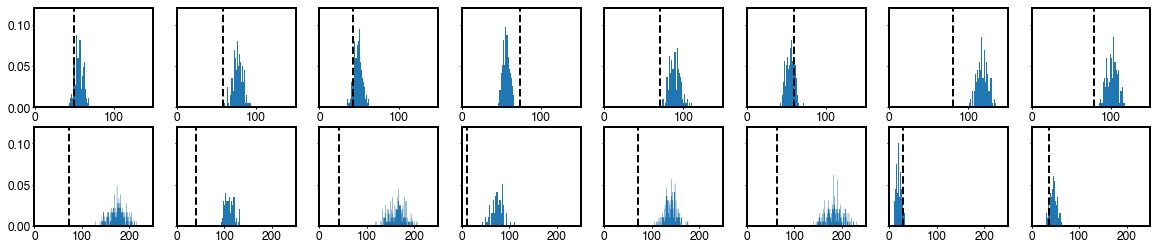

In [23]:
# Single bird

bird = 'B1083'
stim_scm_dict = bird_scm_dict[bird]
bc_tavg = bc_tavg_store[bird]

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
betti_num = 3
bettis = [1,2]
stims = list(bc_tavg.keys())[0:8]
my = 0
for ind, betti_num in enumerate(bettis):
    nmaxyt = 0
    nmaxxt = 0
    for stimind, stim in enumerate(stims):
        final_bettis = bc_tavg[stim][:, -1, 0]
        ax = axs[ind, stimind]
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = final_bettis[betti_num]
        ax.plot([b, b], [0, 100], 'k--', linewidth=2)
        (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxxt = np.amax([nmaxx, nmaxxt])
        if ind > 0:
            xmax = 250
            
            ax.set_xticks(np.arange(0, 300, 100))
        else:
            xmax = 150
    
        ax.set_xlim([-0.1, xmax])
        ax.set_ylim([0, 0.12])
        ax.tick_params(labelsize=12)
        for i in ax.get_xticklabels():
            i.set_fontname('helvetica')
        for i in ax.get_yticklabels():
            i.set_fontname('helvetica')
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
            
        # Calculate empirical p-values
        betti_vals = stim_scm_dict[stim][:, 0, betti_num]
        betti_vals = betti_vals[betti_vals >= 0]
        p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
        if p > 0.5:
            p = 1-p
        print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))
            
        
        #ax.set_title(stim)
plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.eps'.format(bird)))

111.0
140.0
93.0
100.0
168.0
108.0
204.0
176.0
322.0
220.0
309.0
166.0
264.0
346.0
50.0
96.0
117.0
111.0
68.0
135.0
134.0
116.0
116.0
136.0
18.0
21.0
76.0
6.0
4.0
10.0
32.0
3.0
45.0
63.0
69.0
51.0
81.0
32.0
62.0
34.0
112.0
51.0
44.0
99.0
34.0
122.0
39.0
128.0
86.0
40.0
60.0
98.0
116.0
63.0
76.0
80.0
12.0
10.0
58.0
8.0
3.0
46.0
28.0
4.0


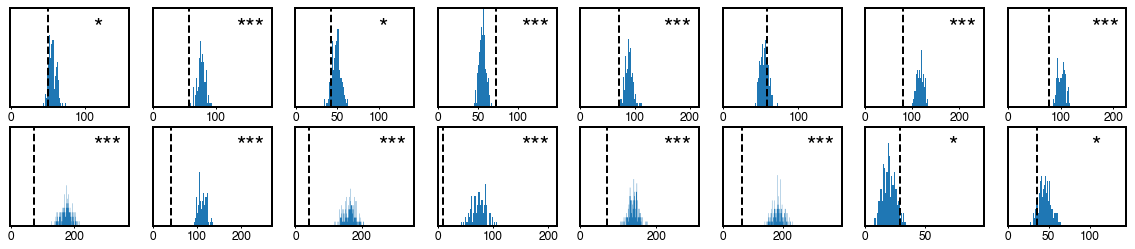

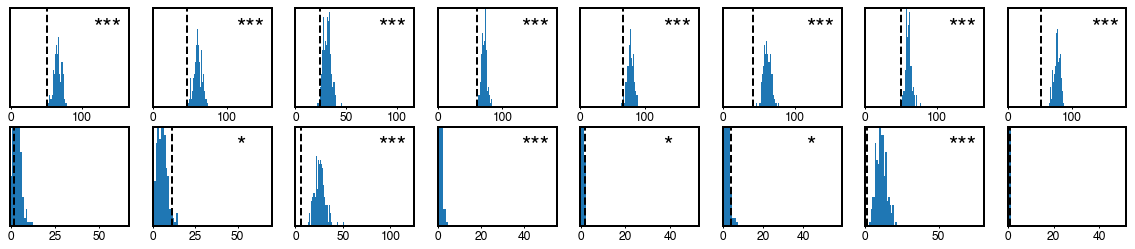

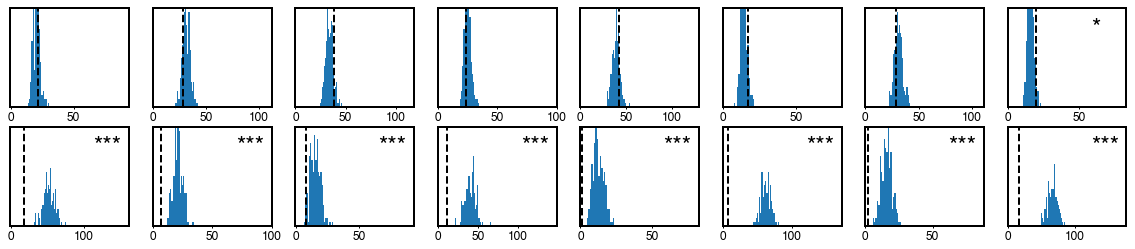

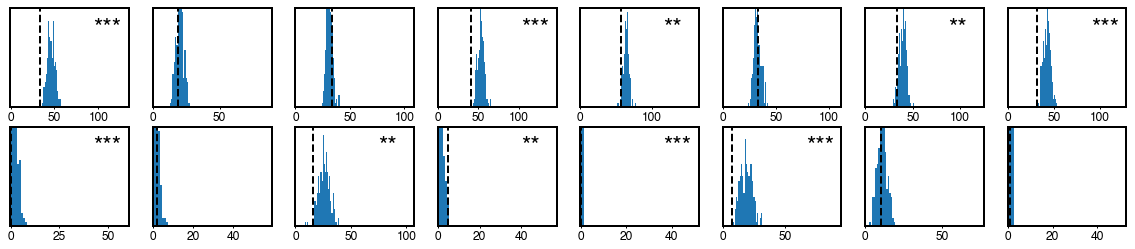

In [39]:
# All bird

for bird in birds:
    stim_scm_dict = bird_scm_dict[bird]
    bc_tavg = bc_tavg_store[bird]

    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
    betti_num = 3
    bettis = [1,2]
    stims = list(bc_tavg.keys())[-8:]
    my = 0
    for ind, betti_num in enumerate(bettis):
        nmaxyt = 0
        nmaxxt = 0
        for stimind, stim in enumerate(stims):
            final_bettis = bc_tavg[stim][:, -1, 0]
            ax = axs[ind, stimind]
            #final_bettis = stim_betticurve_dict[stim][-1]
            b = final_bettis[betti_num]
            ax.plot([b, b], [0, 100], 'k--', linewidth=2)
            (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
            nmaxyt = np.amax([nmaxy, nmaxyt])
            nmaxxt = np.amax([nmaxx, nmaxxt])
            
            if ind > 0:
                xmax = nmaxx+50

                #ax.set_xticks(np.arange(0, 300, 100))
            else:
                xmax = nmaxx+50

            ax.set_xlim([-0.1, xmax])
            ax.set_ylim([0, 0.12])
            ax.tick_params(labelsize=12)
            for i in ax.get_xticklabels():
                i.set_fontname('helvetica')
            for i in ax.get_yticklabels():
                i.set_fontname('helvetica')
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)
            ax.get_yaxis().set_visible(False)
            # Calculate empirical p-values
            betti_vals = stim_scm_dict[stim][:, 0, betti_num]
            betti_vals = betti_vals[betti_vals >= 0]
            p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
            stars = ''
            if p > 0.5:
                p = 1-p
            if p < 0.1:
                stars = '*'
            if p < 0.05:
                stars = '**'
            if p < 0.01:
                stars = '***'
            ax.text(0.7, 0.75, stars, transform=ax.transAxes, fontsize=24)
            #print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))


            #ax.set_title(stim)
    plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.pdf'.format(bird)))